In [1]:
import numpy as np
import pandas as pd
import os
import xarray as xr
import seaborn as sns

from n0_config_params import *
from n0bis_config_analysis_functions import *
from n0ter_stats import *

# Load Data

In [3]:
sujet_list = np.array(['01PD','02MJ','03VN','04GB','05LV','06EF','07PB','08DM','09TA','10BH','11FA','12BD','13FP',
'14MD','15LG','16GM','17JR','18SE','19TM','20TY','21ZV','22DI','23LF','24TJ','25DF','26MN','27BD','28NT','29SC',
'30AR','31HJ','32CM','33MA']) #exclude PB07
session_list = np.array(['o', '+', '-'])
cond_list = np.array(['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2'])

correspondance_odor = {'+' : 'P', 'o' : '0', '-' : 'N'}
correspondance_cond = {'FR_CV1' : 'Variables cycle BL', 'MECA' : 'Variables cycle T1', 'CO2' : 'Variables cycle T2', 'FR_CV2' : 'VS POST'}

df_columns_keep = ['TI', 'Te', 'Ttot', 'BF', 'VT', 'Ve', 'VT/Ti', 'Ti/Ttot', 'PRESS', 'PetCO2', 'VAS S', 'VAS A', 'Temps de début de cycle']

In [4]:
# sujet = 'PD01'
# session_i = 'o'
# cond = 'FR_CV1'

os.chdir(os.path.join(path_data, 'respi_detection'))

for sujet in sujet_list:

    for cond in cond_list:

        for session_i in session_list:

            file_df = [file_i for file_i in os.listdir() if (file_i.find(f'{sujet}') != -1 and file_i.find(f'{correspondance_odor[session_i]}.xlsx') != -1)][0]
            raw_df = pd.read_excel(file_df, sheet_name=correspondance_cond[cond])
            raw_df = raw_df.drop(columns=['INSPI', 'EXPI'])
            raw_df = raw_df.drop([0])
            raw_df_val = raw_df['Temps de début de cycle'].values.astype('float')
            mask = ~np.isnan(raw_df_val)
            raw_df = raw_df.loc[mask,:]
            raw_df = raw_df[df_columns_keep]
            raw_df.insert(0, 'sujet', [sujet]*raw_df.index.shape[0], True)
            raw_df.insert(1, 'cond', [cond]*raw_df.index.shape[0], True)
            raw_df.insert(2, 'session', [session_i]*raw_df.index.shape[0], True)

            if (sujet, cond, session_i) == (sujet_list[0], cond_list[0], session_list[0]): 

                df_respi = raw_df

            else:

                df_respi = pd.concat([df_respi, raw_df])

df_respi = df_respi.reset_index().drop(columns=['index'])
df_respi

IndexError: list index out of range

In [4]:
counts = np.array([])
for sujet in sujet_list:

    for cond in cond_list:

        for session_i in session_list:

            count = df_respi.query(f"sujet == '{sujet}' & cond == '{cond}' & session == '{session_i}'")['Ttot'].shape[0]
            counts = np.append(counts, count)

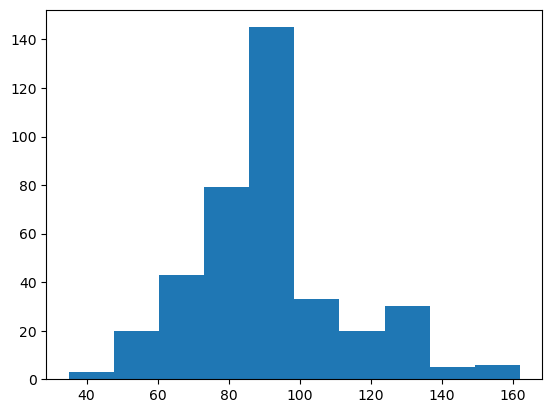

In [5]:
plt.hist(counts)
plt.show()

# DATA LYON

## Load Data

In [9]:
sujet_list = np.array(['01PD','02MJ','03VN','04GB','05LV','06EF','07PB','08DM','09TA','10BH','11FA','12BD','13FP',
'14MD','15LG','16GM','17JR','18SE','19TM','20TY','21ZV','22DI','23LF','24TJ','25DF','26MN','27BD','28NT','29SC',
'30AR','31HJ','32CM','33MA']) #exclude PB07
session_list = np.array(['o', '+', '-'])
cond_list = np.array(['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2'])

In [6]:
metric_tot = ['inspi_index', 'expi_index', 'next_inspi_index',
       'inspi_time', 'expi_time', 'next_inspi_time', 'cycle_duration',
       'inspi_duration', 'expi_duration', 'cycle_freq', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'select']

In [7]:
metric_list = ['inspi_duration', 'expi_duration', 'cycle_freq', 'total_amplitude']

In [11]:
xr_dict = {'sujet' : sujet_list, 'cond' : cond_list, 'session' : session_list, 'metric' : metric_list, 'time' : np.arange(1000)}
xr_data = np.zeros((sujet_list.shape[0], cond_list.shape[0], session_list.shape[0], len(metric_list), 1000))
xr_respi = xr.DataArray(xr_data, dims=xr_dict.keys(), coords=xr_dict.values())

In [12]:
# sujet = 'PD01'
# session_i = 'o'
# cond = 'FR_CV1'

for sujet in sujet_list:

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond in cond_list:

        for session_i in session_list:

            file_df = f'{sujet}_{cond}_{session_i}_respfeatures.xlsx'
            raw_df = pd.read_excel(file_df)

            for metric in metric_list:

                respi_vals = raw_df[metric].values

                f = scipy.interpolate.interp1d(np.linspace(0, 1, respi_vals.shape[0]), respi_vals, kind='linear')
                respi_vals_resampled = f(np.linspace(0, 1, 1000))

                xr_respi.loc[sujet, cond, session_i, metric, :] = respi_vals_resampled


In [13]:
for sujet_i, sujet in enumerate(sujet_list):

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond_i, cond in enumerate(cond_list):

        for session_i, session in enumerate(session_list):

            df_i = pd.read_excel(f'{sujet}_{cond}_{session}_respfeatures.xlsx').drop(columns=['Unnamed: 0'])
            df_header = pd.DataFrame({'sujet' : [sujet]*df_i.shape[0], 'cond' : [cond]*df_i.shape[0], 'session' : [session]*df_i.shape[0]})
            df_i = pd.concat((df_header, df_i), axis=1)

            if sujet_i+cond_i+session_i == 0:
                df_allsujet = df_i
            else:
                df_allsujet = pd.concat((df_allsujet, df_i), axis=0)

In [15]:
df_allsujet = df_allsujet[['sujet', 'cond', 'session']+metric_list]

## EFFECT COND

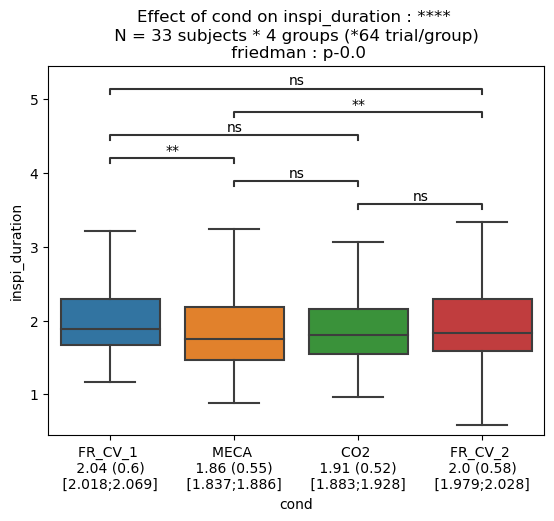

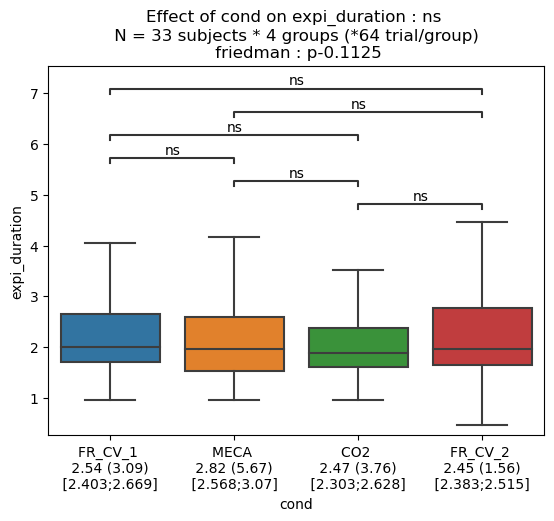

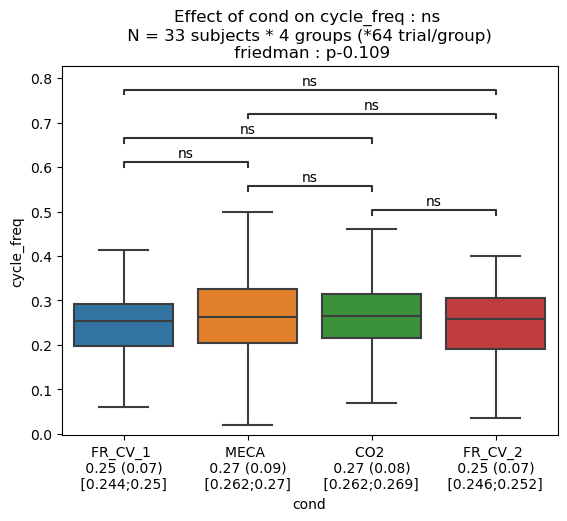

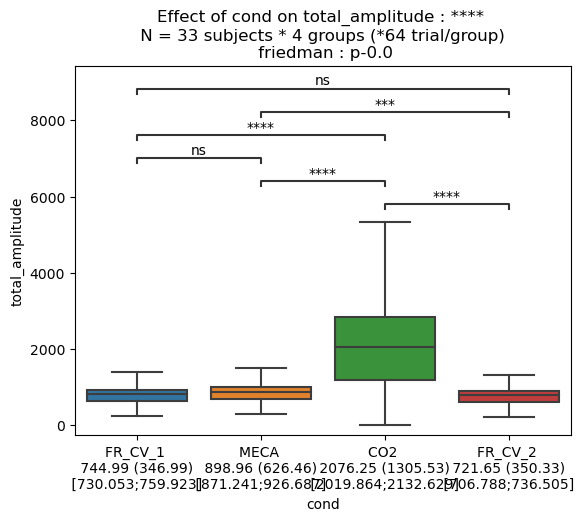

In [50]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

## EFFECT ODOR

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


d:\Anaconda3\lib\site-packages\pingouin\distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
d:\Anaconda3\lib\site-packages\pingouin\distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


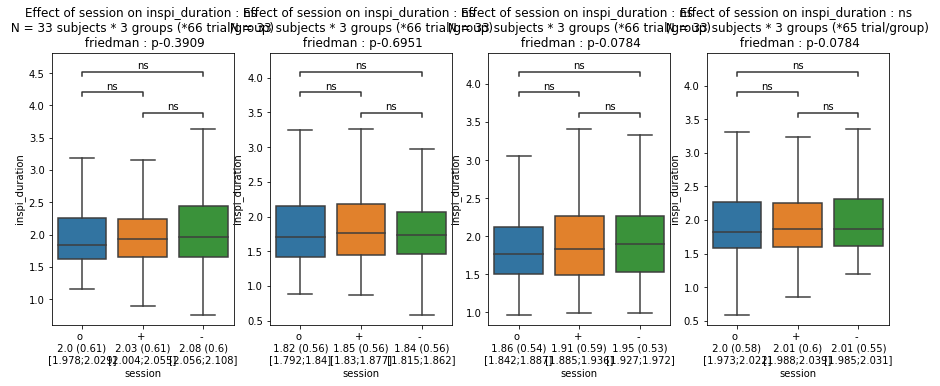

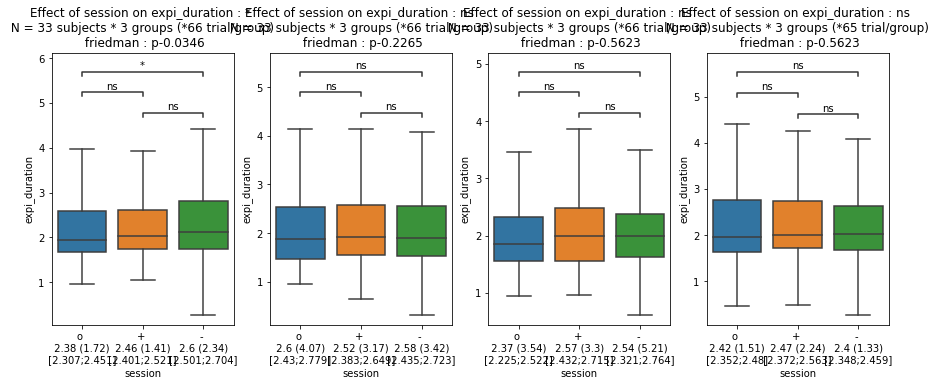

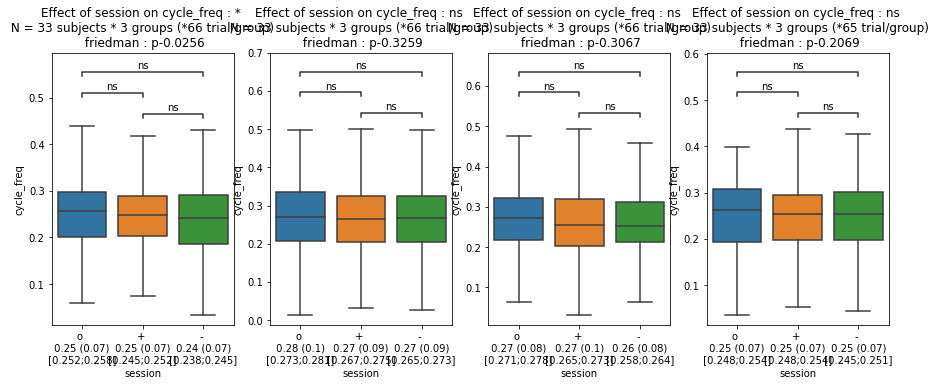

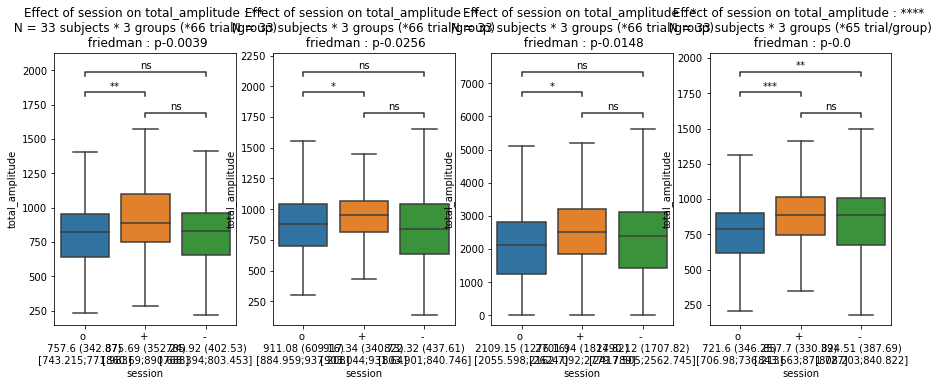

In [16]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

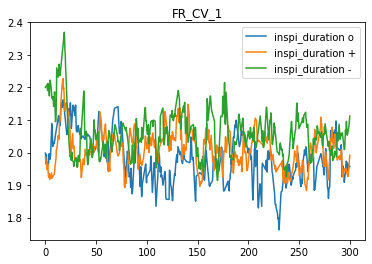

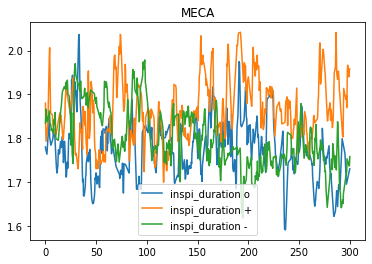

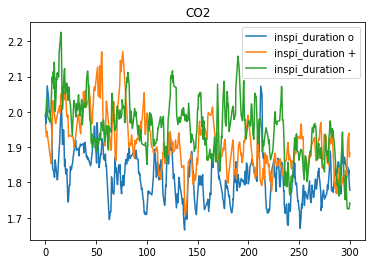

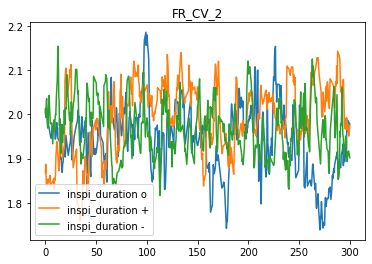

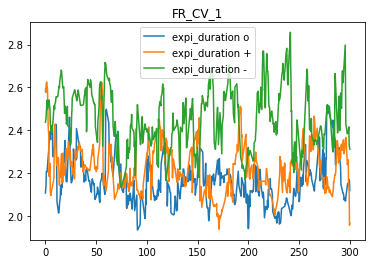

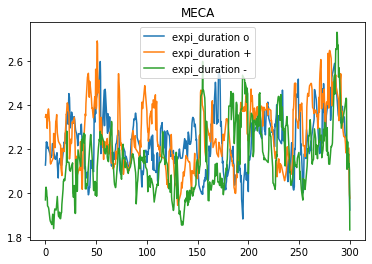

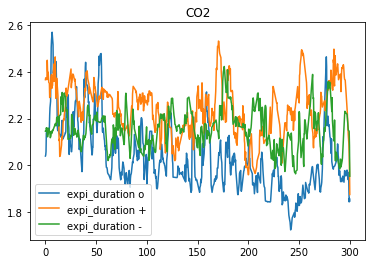

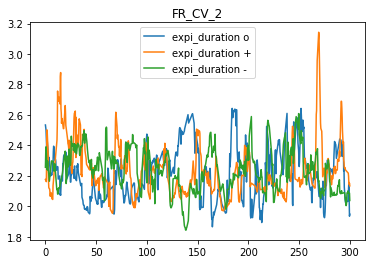

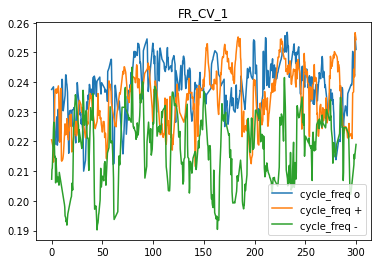

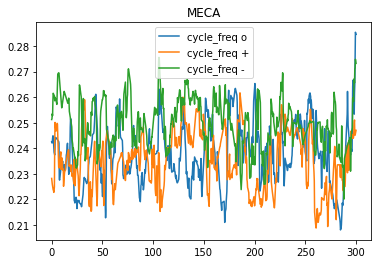

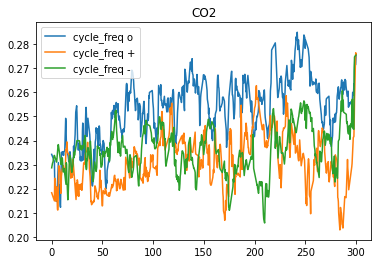

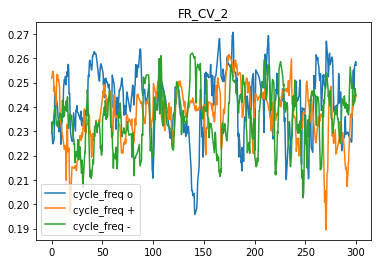

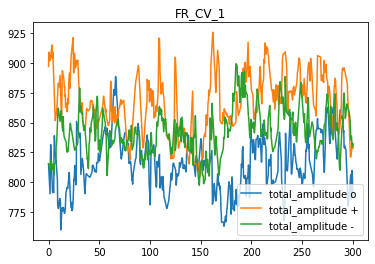

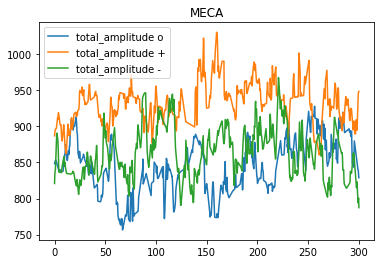

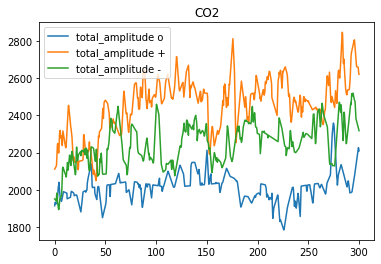

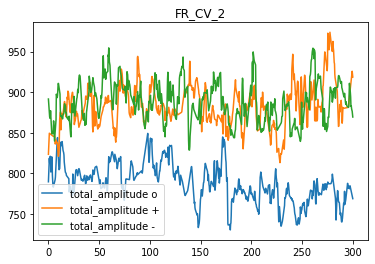

In [18]:
for metric in metric_list:

    for cond in cond_list:

        for session_i in session_list:

            x = xr_respi.loc[:, cond, session_i, metric, :]
            x = np.median(x, axis=0)
            time = np.linspace(0,300,1000)
            plt.plot(time, x, label=f'{metric} {session_i}')

        plt.title(cond)
        plt.legend()
        plt.show()
